In [ ]:
import QuantLib as ql
import pandas as pd
import ql_extension as qle # install via command: pip install git+https://github.com/marekkolman/ql_extension.git

from scipy.stats import norm
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

# Description

Custom implementation of A resetting float-to-float cross-currency swap using `QuantLib`.

Trade attributes are related to 'base' currency leg (which has constant notional and doesn't reset).
FX used is assumed to be in the form BASEFOREIGN, i.e. if base is EUR and USD is foreign, then FX passed is EURUSD (such as 1.2).

Floating leg definitions below are hard-coded for simplicity. User can change this in `build_floating_coupons`.

In [2]:
class xccy_reset:

    '''
        Float-to-Floating resetting xccy swap pricer based on QuantLib
        It incorporates fixings, and multicurves

        Notional, FX are assumed to be wrt the domestic leg. NPV is then also expressed in domestic leg
        For example, if domestic leg is EUR, then FX to be passed in this swap EURUSD (such as 1.2) because EUR is domestic ccy

        Tho 'define' this swap this swap we only need to know its starting date, tenor (years), notional (base ccy) and spreads on the legs, if any

        NOTE that the floating legs are hard coded below (domestic is EURIBOR 1Y, USD is USD LIBOR 1Y). 
             If user wants to change this, function build_floating_coupons(.) has to be changed

    '''
    
    def __init__(self, start_date: ql.Date, years, notional_base, spread_domestic = 0.0, spread_foreign = 0.0):
        '''
            Constructor for resetting xccy swap. It defines the unchangeable elements of the swap: 
                - calendar of dates, 
                - notional of the non-resetting (domestic) leg, 
                - spread on the domestic and foreign legs 
        '''

        self.schedule         = ql.MakeSchedule(start_date, ql.NullCalendar().advance(start_date, ql.Period(years, ql.Years)), ql.Period('1y'), calendar = ql.NullCalendar())
        self.base_notionals   = self.build_base_notionals(self.schedule, notional_base)      
        self.spread_domestic  = spread_domestic
        self.spread_foreign   = spread_foreign 

    def build_swap(self, base_ccy_disc_curve, 
                         base_ccy_fcst_curve, 
                         foreign_ccy_disc_curve, 
                         foreign_ccy_fcst_curve, 
                         spot_fx, 
                         fx_fixings = None, 
                         base_ccy_curve_fixings = None, 
                         foreign_ccy_curve_fixings = None):
        '''
            This function builds the swap cash-flow components that are sensitive to market data. That is:
                - foreign notionals (as these are subject to projected FX rates)
                - domestic leg floating coupons (as these are sensitive to domestic ccy forecasting curve)
                - foreign leg floating coupons (as these are sensitive to foreign ccy forecasting curve)

            The function is called every time NPV is called.
        '''

        if not fx_fixings:
            fx_fixings = {}

        self.foreign_notionals = self.build_foreign_notionals(self.base_notionals, fx_fixings, spot_fx, base_ccy_disc_curve, foreign_ccy_disc_curve)

        self.base_leg_coupons, self.foreign_leg_coupons = self.build_floating_coupons(base_ccy_fcst_curve, 
                                                                                      foreign_ccy_fcst_curve, 
                                                                                      base_ccy_curve_fixings, 
                                                                                      foreign_ccy_curve_fixings)


    def npv(self, base_ccy_disc_curve, 
                  base_ccy_fcst_curve, 
                  foreign_ccy_disc_curve, 
                  foreign_ccy_fcst_curve,
                  spot_fx, 
                  fx_fixings = None, 
                  base_ccy_curve_fixings = None, 
                  foreign_ccy_curve_fixings = None, 
                  info = False):
        '''
            This function computes NPV of the swap in DOMESTIC currency based on current market data.
            NOTE that if we want price during the life of the swap, then past fixings, if we price during the life of the swap

            The following steps are executed by this npv function:
                1. call build_swap() to build foreign notionals, domestic floating leg and foreign floating leg; all depending on evaluationDate data
                2. build i) domestic and ii) foreign legs. This is done by combining notional and floating cash-flow on each leg
                3. compute NPV by discounting the legs. The foreign leg is always converted to the domestic currency (using spot fx) 

            If info=True, then the function returns tuple (npv, base_leg cash flow overview, foreign_leg cash flow overview)

        '''

        self.build_swap(base_ccy_disc_curve, 
                        base_ccy_fcst_curve, 
                        foreign_ccy_disc_curve, 
                        foreign_ccy_fcst_curve, 
                        spot_fx, 
                        fx_fixings, 
                        base_ccy_curve_fixings, 
                        foreign_ccy_curve_fixings)

        base_leg_notionals    = [ql.SimpleCashFlow(notional, date) for date, notional in self.base_notionals[['date', 'notional_cf']].values]
        foreign_leg_notionals = [ql.SimpleCashFlow(notional, date) for date, notional in self.foreign_notionals[['date', 'notional_foreign_currency_cf']].values]

        base_leg    = qle.combine_legs(self.base_leg_coupons,    base_leg_notionals)
        foreign_leg = qle.combine_legs(self.foreign_leg_coupons, foreign_leg_notionals)

        npv = ql.CashFlows.npv(base_leg, base_ccy_disc_curve, False) + ql.CashFlows.npv(foreign_leg, foreign_ccy_disc_curve, False) / spot_fx

        if not info:
            return npv
        else:
            return npv, qle.explore_leg(base_leg), qle.explore_leg(foreign_leg)

    def build_base_notionals(self, schedule, notional):
        '''
            Method builds calendar of base-currency notionals.
            It gets called only once in constructor because the domestic currency notionals are given and don't reset; So their schedule doesn't change
        '''
        notional_calendar = pd.Series(list(schedule),name = 'date').to_frame()

        notional_exchange = [None]*len(notional_calendar)
        notional_exchange[0]  = notional
        notional_exchange[-1] = -notional

        notionals     = [notional]*len(notional_calendar)
        notionals[-1] = 0

        notional_calendar['notional_exchange'] = notional_exchange
        notional_calendar['notional'] = notionals
        notional_calendar['notional_cf'] = notional_calendar['notional_exchange'].fillna(0)
        return notional_calendar

    def build_foreign_notionals(self, notional_calendar_base, fx_fixings, spot_fx, base_ccy_disc_curve, foreign_ccy_disc_curve):
        '''
            This function builds the foreign-notionals leg (that reset).
            The function gets called every time we compute NPV because the foreign notionals are subject to market data
        '''
        
        def implied_rate(date: ql.Date, spot_fx, base_ccy_curve, foreign_ccy_curve): return spot_fx * base_ccy_curve.discount(date)/foreign_ccy_curve.discount(date)
        
        notional_calendar = notional_calendar_base[['date']].copy()
        notional_calendar['notional_base_currency'] = - notional_calendar_base['notional'].copy()
        implied_rates = notional_calendar['date'].map(lambda date: implied_rate(date, spot_fx, base_ccy_disc_curve, foreign_ccy_disc_curve))
        notional_calendar['fx'] = notional_calendar['date'].map(fx_fixings).fillna(implied_rates)

        notional_calendar['notional_foreign_currency'] = notional_calendar.eval('notional_base_currency * fx')

        notional_adjustments          = notional_calendar['notional_foreign_currency'].diff().values
        notional_adjustments[[0, -1]] = None
        notional_calendar['notional_adj_foreign_currency'] = notional_adjustments

        notional_exchanges = [None]*len(notional_calendar)
        notional_exchanges[0] = notional_calendar['notional_foreign_currency'].iloc[0]
        notional_exchanges[-1] = -notional_calendar['notional_foreign_currency'].iloc[-2]
        notional_calendar['notional_exchange_foreign_currency'] = notional_exchanges
        notional_calendar['notional_foreign_currency_cf'] = notional_calendar[['notional_adj_foreign_currency', 'notional_exchange_foreign_currency']].sum(axis = 1)
        return notional_calendar

    def build_floating_coupons(self, base_ccy_fcst_curve, foreign_ccy_fcst_curve, base_ccy_curve_fixings = None, foreign_ccy_curve_fixings = None):
        '''
            Function makes a projection of floating legs cash-flows.
            This function gets called every time NPV gets executed as floating coupons are recalculated based on current market data

            Definiton of floating rates is hard-coded here (EURIBOR 1Y on domestic leg and USD LIBOR on foreign leg). This can be easily changed.

            Note that if we price already running swap, fixings need to be provided 
        '''
        idx1 = ql.Euribor(ql.Period(1, ql.Years), base_ccy_fcst_curve)
        idx1.clearFixings()
        if base_ccy_curve_fixings:
            unzip_dates, unzip_fixings = zip(*base_ccy_curve_fixings.items())
            idx1.addFixings(list(unzip_dates), list(unzip_fixings), forceOverwrite=True)
        base_leg_coupons = ql.IborLeg((-self.base_notionals['notional'].iloc[:-1]).to_list(), self.schedule, idx1, ql.SimpleDayCounter(), fixingDays = [2], spreads = [self.spread_domestic])


        idx2 = ql.USDLibor(ql.Period(1, ql.Years), foreign_ccy_fcst_curve)
        idx2.clearFixings()
        if foreign_ccy_curve_fixings:
            unzip_dates, unzip_fixings = zip(*foreign_ccy_curve_fixings.items())
            idx2.addFixings(list(unzip_dates), list(unzip_fixings))
        foreign_leg_coupons = ql.IborLeg((-self.foreign_notionals['notional_foreign_currency'].iloc[:-1]).to_list(), self.schedule, idx2, ql.SimpleDayCounter(), fixingDays = [2], spreads = [self.spread_foreign])

        return base_leg_coupons, foreign_leg_coupons


# Test of NPV as of $t=0$ (2022-08-18)
For simplicity we assume flat yield curves. We also assume discounting curve = forecasting curve but the implementation supports different forecasting and discounting curves.

In [3]:
date = ql.Date(18, 8, 2022)
ql.Settings.instance().evaluationDate = date
eur_rate = 0.02
usd_rate = 0.03
spot_fx  = 1.2

eur_curve = ql.YieldTermStructureHandle(ql.FlatForward(date, ql.QuoteHandle(ql.SimpleQuote(eur_rate)),ql.SimpleDayCounter()))
usd_curve = ql.YieldTermStructureHandle(ql.FlatForward(date, ql.QuoteHandle(ql.SimpleQuote(usd_rate)),ql.SimpleDayCounter()))

swap = xccy_reset(date, 5, 100, spread_domestic=0.0)
                  
npv, base, foreign = swap.npv(base_ccy_disc_curve = eur_curve, 
                              base_ccy_fcst_curve = eur_curve,
                              foreign_ccy_disc_curve = usd_curve,
                              foreign_ccy_fcst_curve = usd_curve, 
                              spot_fx = spot_fx, 
                              fx_fixings = None, 
                              base_ccy_curve_fixings    = {ql.Date(16, 8, 2022): eur_rate}, 
                              foreign_ccy_curve_fixings = {ql.Date(16, 8, 2022): usd_rate},
                              info = True)

print(f'NPV in base currency is {npv}')
display(base)
display(foreign)
display(swap.base_notionals)
display(swap.foreign_notionals)


NPV in base currency is -0.07779056781427585


,date,amount,accrualDays,accrualEndDate,accrualPeriod,accrualStartDate,dayCounter,exCouponDate,nominal,rate,fixingDate,spread,referencePeriodEnd,referencePeriodStart
0,"August 18th, 2023",-2.000000,360.0,"August 18th, 2023",1.0,"August 18th, 2022",Simple day counter,null date,-100.0,0.020000,"August 16th, 2022",0.0,"August 18th, 2023","August 18th, 2022"
1,"August 18th, 2024",-1.987163,360.0,"August 18th, 2024",1.0,"August 18th, 2023",Simple day counter,null date,-100.0,0.019872,"August 16th, 2023",0.0,"August 18th, 2024","August 18th, 2023"
2,"August 18th, 2025",-1.992329,360.0,"August 18th, 2025",1.0,"August 18th, 2024",Simple day counter,null date,-100.0,0.019923,"August 15th, 2024",0.0,"August 18th, 2025","August 18th, 2024"
3,"August 18th, 2026",-1.992461,360.0,"August 18th, 2026",1.0,"August 18th, 2025",Simple day counter,null date,-100.0,0.019925,"August 14th, 2025",0.0,"August 18th, 2026","August 18th, 2025"
4,"August 18th, 2027",-1.992461,360.0,"August 18th, 2027",1.0,"August 18th, 2026",Simple day counter,null date,-100.0,0.019925,"August 14th, 2026",0.0,"August 18th, 2027","August 18th, 2026"
5,"August 18th, 2022",100.000000,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None
6,"August 18th, 2023",0.000000,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None
7,"August 18th, 2024",0.000000,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None
8,"August 18th, 2025",0.000000,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None
9,"August 18th, 2026",0.000000,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None


,date,amount,accrualDays,accrualEndDate,accrualPeriod,accrualStartDate,dayCounter,exCouponDate,nominal,rate,fixingDate,spread,referencePeriodEnd,referencePeriodStart
0,"August 18th, 2023",3.600000,360.0,"August 18th, 2023",1.0,"August 18th, 2022",Simple day counter,null date,120.000000,0.030000,"August 16th, 2022",0.0,"August 18th, 2023","August 18th, 2022"
1,"August 18th, 2024",3.631077,360.0,"August 18th, 2024",1.0,"August 18th, 2023",Simple day counter,null date,121.206020,0.029958,"August 16th, 2023",0.0,"August 18th, 2024","August 18th, 2023"
2,"August 18th, 2025",3.677003,360.0,"August 18th, 2025",1.0,"August 18th, 2024",Simple day counter,null date,122.424161,0.030035,"August 15th, 2024",0.0,"August 18th, 2025","August 18th, 2024"
3,"August 18th, 2026",3.714255,360.0,"August 18th, 2026",1.0,"August 18th, 2025",Simple day counter,null date,123.654544,0.030037,"August 14th, 2025",0.0,"August 18th, 2026","August 18th, 2025"
4,"August 18th, 2027",3.751584,360.0,"August 18th, 2027",1.0,"August 18th, 2026",Simple day counter,null date,124.897293,0.030037,"August 14th, 2026",0.0,"August 18th, 2027","August 18th, 2026"
5,"August 18th, 2022",-120.000000,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None
6,"August 18th, 2023",-1.206020,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None
7,"August 18th, 2024",-1.218141,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None
8,"August 18th, 2025",-1.230383,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None
9,"August 18th, 2026",-1.242749,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None


,date,notional_exchange,notional,notional_cf
0,"August 18th, 2022",100.0,100,100.0
1,"August 18th, 2023",NaN,100,0.0
2,"August 18th, 2024",NaN,100,0.0
3,"August 18th, 2025",NaN,100,0.0
4,"August 18th, 2026",NaN,100,0.0
5,"August 18th, 2027",-100.0,0,-100.0


,date,notional_base_currency,fx,notional_foreign_currency,notional_adj_foreign_currency,notional_exchange_foreign_currency,notional_foreign_currency_cf
0,"August 18th, 2022",-100,1.200000,-120.000000,NaN,-120.000000,-120.000000
1,"August 18th, 2023",-100,1.212060,-121.206020,-1.206020,NaN,-1.206020
2,"August 18th, 2024",-100,1.224242,-122.424161,-1.218141,NaN,-1.218141
3,"August 18th, 2025",-100,1.236545,-123.654544,-1.230383,NaN,-1.230383
4,"August 18th, 2026",-100,1.248973,-124.897293,-1.242749,NaN,-1.242749
5,"August 18th, 2027",0,1.261525,0.000000,NaN,124.897293,124.897293


# Simulation
The idea is to simulate FX over 5 years and show how the NPV returns to 0 due to the notional resets.

For simplicity we presimulate FX and will keep the IR constant.

In [4]:

date = ql.Date(18, 8, 2022)
ql.Settings.instance().evaluationDate = date
eur_rate = 0.02
usd_rate = 0.03

eur_curve = ql.YieldTermStructureHandle(ql.FlatForward(date, ql.QuoteHandle(ql.SimpleQuote(eur_rate)),ql.SimpleDayCounter()))
usd_curve = ql.YieldTermStructureHandle(ql.FlatForward(date, ql.QuoteHandle(ql.SimpleQuote(usd_rate)),ql.SimpleDayCounter()))

# fixing dates. Interest rate fixing will be stored for those days to mimit standard fixings
fixing_days_ir = [ql.Date(16,8,2022), ql.Date(16,8,2023), ql.Date(15,8,2024), ql.Date(14,8,2025), ql.Date(14,8,2026)]
fixing_days_fx = [ql.Date(18,8,2022), ql.Date(18,8,2023), ql.Date(18,8,2024), ql.Date(18,8,2025), ql.Date(18,8,2026)]

# simulaiton days
days = [date + offset for offset in range(0, ql.Date(18, 8, 2027)-date+1)]

# simulate FX
fx = [1.2]
for _ in range(len(days)-1):
    fx.append(fx[-1] + norm.rvs()*0.01)

# store pre-simulated FX to a dict
fx_fixings_simulated = {dt: fixing for dt, fixing in zip(days, fx)}

# as of t0 we know only the current t0 FX
fx_fixings = {date: fx[0]}
base_ccy_curve_fixings = {ql.Date(16, 8, 2022): eur_rate}
foreign_ccy_curve_fixings = {ql.Date(16, 8, 2022): usd_rate}

swap = xccy_reset(date, years = 5, notional_base = 100)
npvs = []
for day in days:
    ql.Settings.instance().evaluationDate = day
    if day in fixing_days_fx:
        fx_fixings[day] = fx_fixings_simulated[day]

    if day in fixing_days_ir:
        base_ccy_curve_fixings[day]    = eur_rate
        foreign_ccy_curve_fixings[day] = usd_rate
    
    npv = swap.npv(base_ccy_disc_curve = eur_curve, 
                   base_ccy_fcst_curve = eur_curve,
                   foreign_ccy_disc_curve = usd_curve,
                   foreign_ccy_fcst_curve = usd_curve, 
                   spot_fx    = fx_fixings_simulated[day], 
                   fx_fixings = fx_fixings, 
                   base_ccy_curve_fixings = base_ccy_curve_fixings, 
                   foreign_ccy_curve_fixings = foreign_ccy_curve_fixings, 
                   info = False)
    npvs.append(npv)

ql.Settings.instance().evaluationDate = date

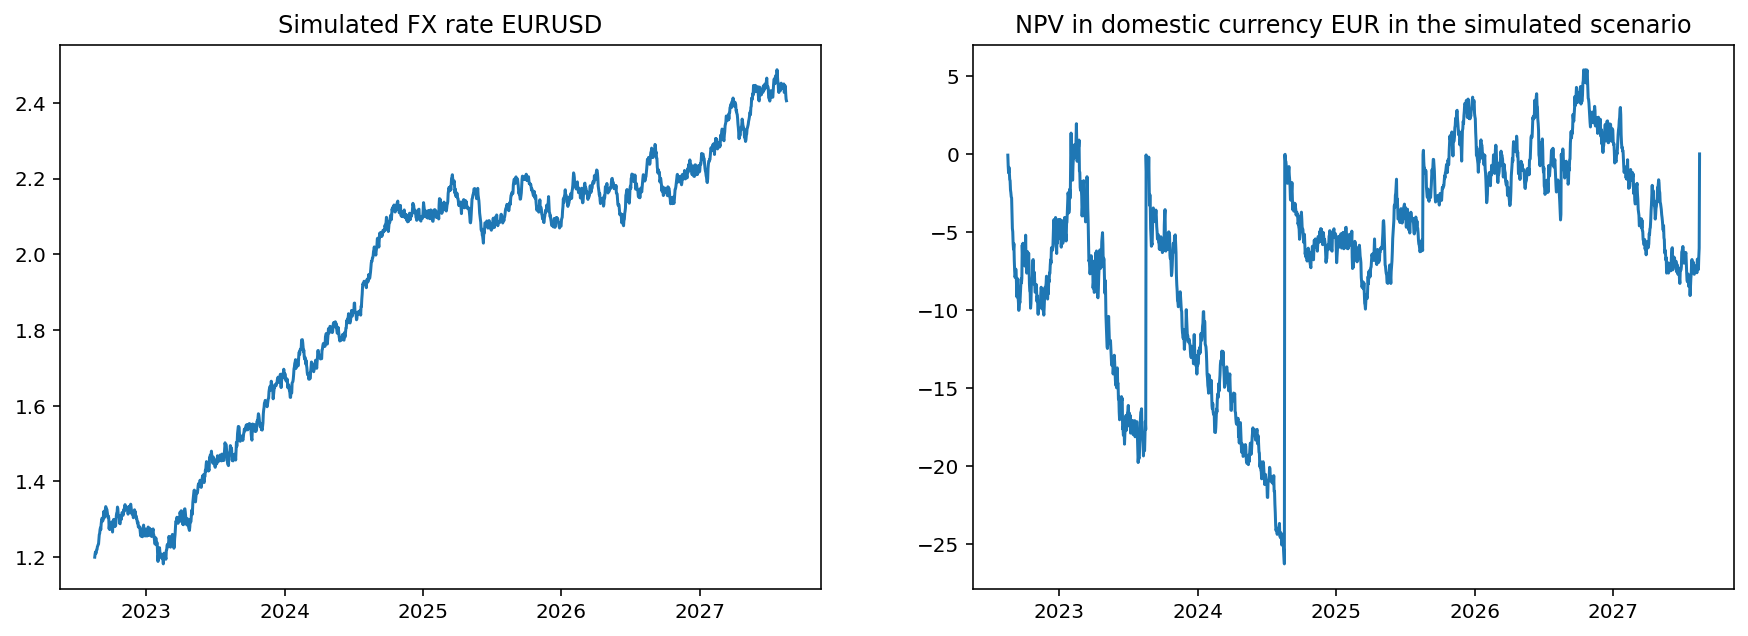

In [5]:
# display results
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))

ax[0].plot([dt.to_date() for dt in days], fx);
ax[0].set_title('Simulated FX rate EURUSD');
ax[1].plot([dt.to_date() for dt in days], npvs);
ax[1].set_title('NPV in domestic currency EUR in the simulated scenario');
